# Basis function construction



This now creates basis functions for both the observations and for a week(?) of mobile data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import datetime

### Load grid 

(we'll need to filter this down)

In [6]:
grid_gdf = geopandas.read_file("./data/coarse_grid_pts/grid_pts_coarse.shp")

<Axes: >

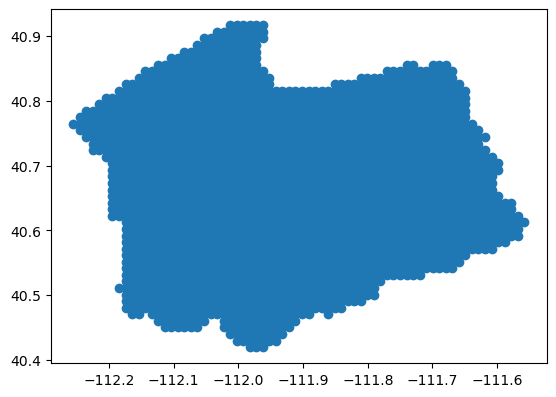

In [7]:
grid_gdf.plot()

In [11]:
min_x = grid_crds.x.min()
max_x = grid_crds.x.max()
min_y = grid_crds.y.min()
max_y = grid_crds.y.max()
print(min_x, max_x, min_y, max_y)


-112.25516635714284 -111.55831564285714 40.419293290000006 40.916769710000004


### Load monitor data

In [2]:
aq_df = pd.read_csv("./data/aqs_data.csv")
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement
0,2005,40.598056,-111.894167,Ozone,2023-01-01T00:00:00Z,2023-01-01,0S,0.014
1,2005,40.598056,-111.894167,Ozone,2023-01-01T01:00:00Z,2023-01-01,1H 0M 0S,0.007
2,2005,40.598056,-111.894167,Ozone,2023-01-01T02:00:00Z,2023-01-01,2H 0M 0S,0.002
3,2005,40.598056,-111.894167,Ozone,2023-01-01T03:00:00Z,2023-01-01,3H 0M 0S,0.009
4,2005,40.598056,-111.894167,Ozone,2023-01-01T04:00:00Z,2023-01-01,4H 0M 0S,0.011


In [3]:
# aq_df = aq_df[(aq_df.day_time >= "2023-01-08") & (aq_df.day_time <= "2023-01-14")]
aq_df = aq_df[aq_df.day_time <= "2023-01-14"]

In [4]:
aq_df.shape

(2480, 8)

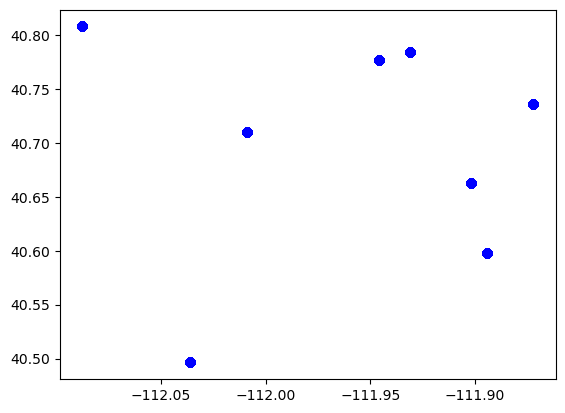

In [5]:
plt.plot(aq_df['longitude'], aq_df['latitude'], 'bo')

In [12]:
lon = aq_df.values[:,2].astype('float64')
lat = aq_df.values[:,1].astype('float64')
normalized_lon = (lon-min_x)/(max_x - min_x)
normalized_lat = (lat-min_y)/(max_y-min_y)
N = lon.shape[0]
print(N)

1144


Load ebus data

In [9]:
ebus = pd.read_csv("./data/EBUS_TEST_DATA/BUS04_2023_06.csv", header = [0,1],  
                 na_values = -9999.00)

In [27]:
ebus.shape

(151537, 27)

In [21]:
ebus.head()

,Timestamp,Latitude,Longitude,Elevation,GPS_Speed,GPS_Direction,GPS_RMC_Valid,Battery_Voltage,Bus_Box_Temperature,Bus_Top_Temperature,...,ES405_Internal_Relative_Humidity,ES405_Internal_Air_Pressure,ES405_Error_Code,2B_Ozone_Concentration,2B_Air_Flow_Rate,2B_Internal_Air_Temperature,2B_Internal_Air_Pressure,PM2.5_Data_Flagged,Ozone_Data_Flagged,GPS_Data_Flagged
,UTC,ddeg,ddeg,m,m/s,deg,binary,volts,degC,degC,...,%,hpa,code,ppbv,L/min,degC,hpa,binary,binary,binary
0,2023-06-01T00:00:00,40.767262,-111.865799,1348.7,0.0,275.8,1.0,13.39,25.76,24.68,...,21.1,643.9,0.0,51.5,2.14,37.0,826.4,0,0,0
1,2023-06-01T00:00:05,40.767262,-111.865799,1348.7,0.0,275.8,1.0,13.38,25.76,24.68,...,NaN,NaN,NaN,44.2,2.13,37.0,826.7,0,0,0
2,2023-06-01T00:00:10,40.767262,-111.865799,1348.7,0.0,275.8,1.0,13.39,25.76,24.68,...,NaN,NaN,NaN,49.4,2.14,37.0,826.8,0,0,0
3,2023-06-01T00:00:15,40.767262,-111.865799,1348.7,0.0,275.8,1.0,13.38,25.76,24.70,...,NaN,NaN,NaN,49.4,2.15,37.0,826.5,0,0,0
4,2023-06-01T00:00:20,40.767262,-111.865799,1348.7,0.0,275.8,1.0,13.39,25.76,24.70,...,NaN,NaN,NaN,46.0,2.14,37.0,826.4,0,0,0


In [29]:
ebus2 = pd.DataFrame({
    'time': pd.to_datetime(ebus.iloc[:,0]),
    'time': pd.to_datetime(ebus.iloc[:,0]),
    'time': pd.to_datetime(ebus.iloc[:,0]),
    'time': pd.to_datetime(ebus.iloc[:,0]),
    })

In [30]:
ebus2

,time
0,2023-06-01 00:00:00
1,2023-06-01 00:00:05
2,2023-06-01 00:00:10
3,2023-06-01 00:00:15
4,2023-06-01 00:00:20
...,...
151532,2023-06-30 23:59:35
151533,2023-06-30 23:59:40
151534,2023-06-30 23:59:45
151535,2023-06-30 23:59:50


In [22]:
pd.to_datetime(ebus['Timestamp'], format='%Y-%m-%dT%H:%M:%S')

ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

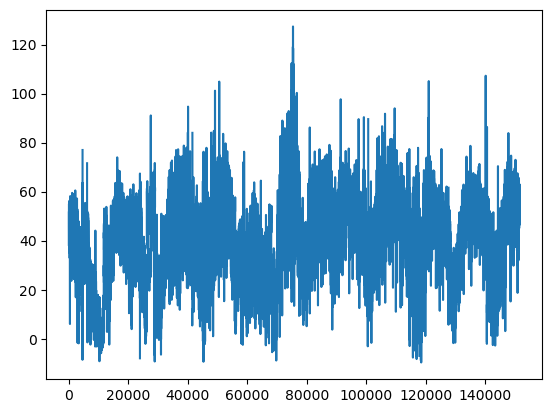

In [10]:
plt.plot(ebus['2B_Ozone_Concentration'])

### Time

In [13]:
aq_df.head()

,site.num,latitude,longitude,parameter.name,day_time,date,hour,sample.measurement
167,2005,40.598056,-111.894167,Ozone,2023-01-08T00:00:00Z,2023-01-08,0S,0.031
168,2005,40.598056,-111.894167,Ozone,2023-01-08T01:00:00Z,2023-01-08,1H 0M 0S,0.032
169,2005,40.598056,-111.894167,Ozone,2023-01-08T02:00:00Z,2023-01-08,2H 0M 0S,0.030
170,2005,40.598056,-111.894167,Ozone,2023-01-08T03:00:00Z,2023-01-08,3H 0M 0S,0.031
171,2005,40.598056,-111.894167,Ozone,2023-01-08T04:00:00Z,2023-01-08,4H 0M 0S,0.031


In [14]:
day_time = aq_df['day_time']
day_time = pd.to_datetime(day_time)
# add the timezone:

print(day_time[0:10])
print(day_time.dtype)

167   2023-01-08 00:00:00+00:00
168   2023-01-08 01:00:00+00:00
169   2023-01-08 02:00:00+00:00
170   2023-01-08 03:00:00+00:00
171   2023-01-08 04:00:00+00:00
172   2023-01-08 05:00:00+00:00
173   2023-01-08 06:00:00+00:00
174   2023-01-08 07:00:00+00:00
175   2023-01-08 08:00:00+00:00
176   2023-01-08 09:00:00+00:00
Name: day_time, dtype: datetime64[ns, UTC]
datetime64[ns, UTC]


In [15]:
day_time = day_time.astype('int64') / 1e9 ## Time in nanoseconds

In [16]:
min_t = day_time.min()
max_t = day_time.max()
print(min_t, max_t)

1673136000.0 1673650800.0


In [17]:
aq_df['day_time2'] = (day_time - min_t) / (max_t-min_t)
aq_df['day_time2']

167      0.000000
168      0.006993
169      0.013986
170      0.020979
171      0.027972
           ...   
45645    0.972028
45646    0.979021
45647    0.986014
45648    0.993007
45649    1.000000
Name: day_time2, Length: 1144, dtype: float64

## Basis functions

### Time

In [18]:
s = np.array(aq_df['day_time2']).reshape(len(aq_df),1)
print(s.shape)
N_data = len(aq_df)
N = N_data ## We have a separate N for the training + test data set (no testing at present)
print(N)

(1144, 1)
1144


We need to define:
- Number of basis layers (3)
- Number of knots per layer
- S.D. for Gaussian function

Then make a ragged array holding the knots on the normalized scale.

Note that one of the previous examples has a very high number of temporal knots (~800) which is very computationally expensive

In [19]:
## time basis 
num_basis = [10,15,45]
std_arr = [0.4,0.2,0.1]
num_basis = [10,20,56]
std_arr = [0.3,0.15,0.05]
#num_basis = [70,250,410]
#std_arr = [0.2,0.09,0.009]
#std_arr = [0.3,0.15,0.05]

mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]

In [20]:
mu_knots

[array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([0.        , 0.01818182, 0.03636364, 0.05454545, 0.07272727,
        0.09090909, 0.10909091, 0.12727273, 0.14545455, 0.16363636,
        0.18181818, 0.2       , 0.21818182, 0.23636364, 0.25454545,
        0.27272727, 0.29090909, 0.30909091, 0.32727273, 0.34545455,
        0.36363636, 0.38181818, 0.4       , 0.41818182, 0.43636364,
        0.45454545, 0.47272727, 0.49090909, 0.50909091, 0.52727273,
        0.54545455, 0.56363636, 0.58181818, 0.6       , 0.61818182,
        0.63636364, 0.65454545, 0.67272727, 0.69090909, 0.70909091,
        0.72727273, 0.74545455, 0.76363636, 

Now create the basis functions. This does the following:
- Loop over each basis layer
- Loop by knot in the selected layer
- Get distance from each observation (held in `s`) to the knot
- Estimate Gaussian weight

In [21]:
phi_t = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t[j,i + K] = 0
    K = K + num_basis[res]

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_84296/420065419.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


Plot basis functions at location (time) 0

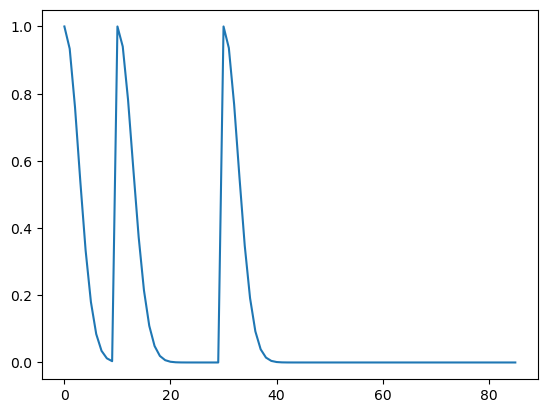

In [22]:
plt.plot(phi_t[0,:])
#plt.plot(phi_t[25000,:])
plt.show()

Plot first basis function (over all time)

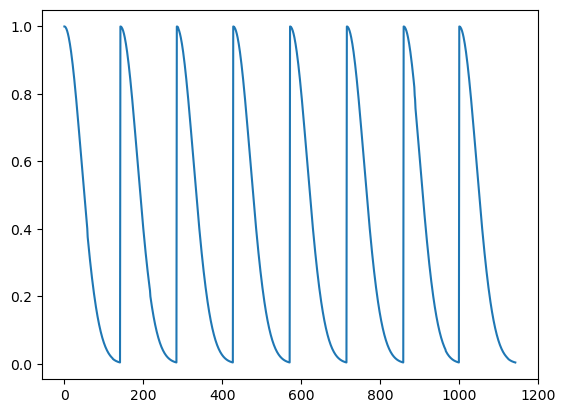

In [23]:
plt.plot(phi_t[:,0])

### Space

In [24]:
s = np.vstack((normalized_lon,normalized_lat)).T

In [25]:
## Knots for spatial dimension (from STDK example)
num_basis = [5**2,9**2,11**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]

In [26]:
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

Basis function for first location

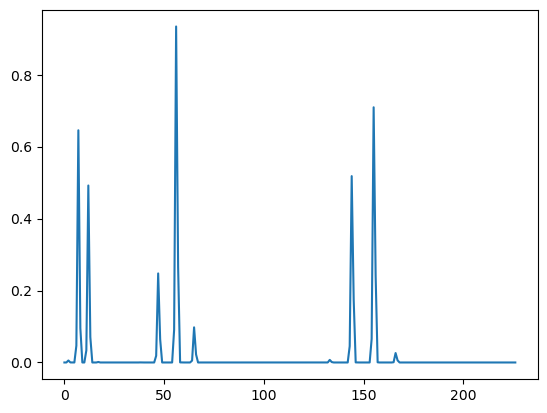

In [27]:
plt.plot(phi[0,:])

In [28]:
x = phi[0,0:25]
x = x.reshape(5, 5)

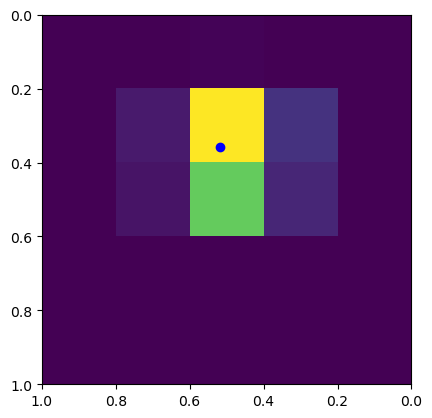

In [29]:
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(normalized_lon[0], normalized_lat[0], 'bo')
plt.show()

In [30]:
num_basis

[25, 81, 121]

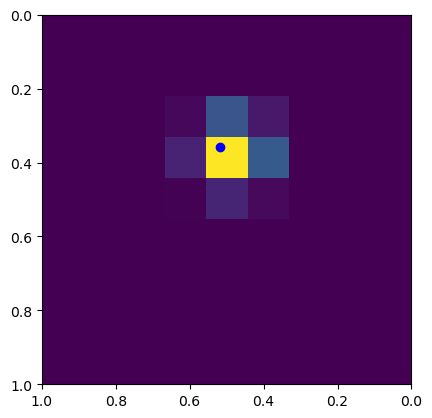

In [31]:
x = phi[0,25:106]
x = x.reshape(9, 9)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(normalized_lon[0], normalized_lat[0], 'bo')
plt.show()


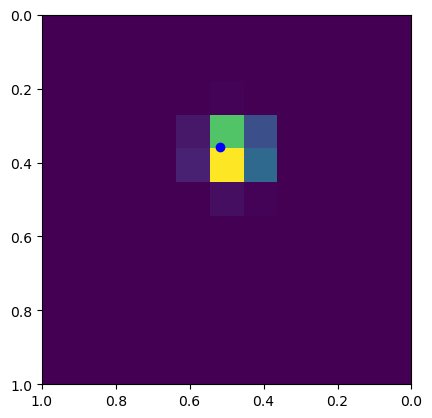

In [32]:
x = phi[0,106:227]
x = x.reshape(11, 11)
plt.imshow(x, extent=[1, 0, 1, 0])
plt.plot(normalized_lon[0], normalized_lat[0], 'bo')
plt.show()


Check dimensions and stack (column bind)

In [33]:
print(phi_t.shape)
print(phi.shape)

phi2 = np.hstack((phi_t,phi))

(1144, 86)
(1144, 227)


Remove any columns with all zeros (basis functions not linked to obs)

In [34]:
idx_zero = np.array([], dtype=int)
for i in range(phi2.shape[1]):
    if sum(phi2[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_reduce = np.delete(phi2,idx_zero,1)
print(phi2.shape)
print(phi_reduce.shape)

(1144, 313)
(1144, 217)


Write out

In [35]:
np.save("./rbfs/phi_short_full.npy", phi2)
np.save("./rbfs/phi_short_reduce.npy", phi_reduce)

In [36]:
y = np.array(aq_df["sample.measurement"])
np.save("./rbfs/y_short.npy", y)
#y.min()

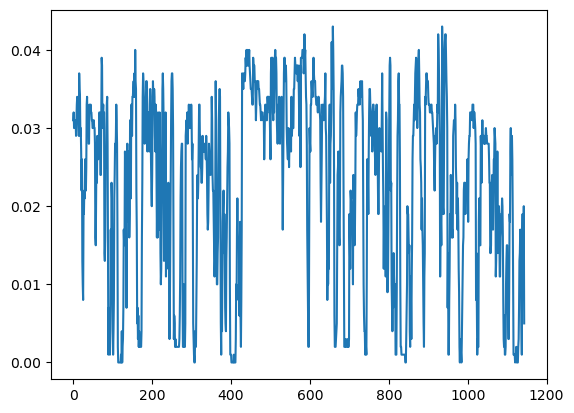

In [37]:
plt.plot(y)

In [38]:
df_y = pd.DataFrame(y)
#df_y.to_csv("./rbfs/y.csv")

In [39]:
df = pd.DataFrame(phi2)
df['y'] = df_y[0]
df['site'] = aq_df['site.num'].to_numpy()
df['date'] = aq_df['date'].to_numpy()
df.to_csv("./rbfs/phi_short_full.csv")
df = pd.DataFrame(phi_reduce)
df['y'] = df_y[0]
df['site'] = aq_df['site.num'].to_numpy()
df['date'] = aq_df['date'].to_numpy()
df.to_csv("./rbfs/phi_short_reduce.csv")

In [40]:
df['site']

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
1139    4002
1140    4002
1141    4002
1142    4002
1143    4002
Name: site, Length: 1144, dtype: int64